In [7]:
from PIL import Image
from tqdm import tqdm
import numpy as np
import cv2
import os
from sklearn.model_selection import train_test_split
from skimage.io import imread
from skimage.transform import pyramid_reduce, resize

#이미지 불러오기

train_path = 'C:/MLDL/crop_train_result/necrosis/'
mask_path = 'C:/MLDL/crop_train_mask_result/necrosis/'

train_list = os.listdir(train_path)
mask_list = os.listdir(mask_path)
#X를 uint8로 해야하나
X = np.zeros((len(train_list), 31,31, 3), dtype=np.uint8)
Y = np.zeros((len(mask_list), 31,31, 1), dtype=np.bool)

for n, name in tqdm(enumerate(train_list), total=len(train_list)):
    path = train_path + name
    img = imread(path)
    img = resize(img, output_shape=(31,31,3), preserve_range=True)
    X[n]=np.array(img)

for n, maskname in tqdm(enumerate(mask_list), total = len(mask_list)):
#for n, maskname in enumerate(mask_list):
    path = mask_path + maskname
    mask=imread(path,as_gray=True)
    mask = resize(mask, output_shape=(31,31,1), preserve_range=True)
    Y[n] = np.array(mask)
    
    
    
x_train, x_val, y_train, y_val = train_test_split(X, Y, test_size=0.1)
savepath='C:/MLDL/npy/necrosis/'
np.save(savepath+'x_train_necrosis', x_train)
np.save(savepath+'y_train_necrosis', y_train)
np.save(savepath+'x_val_necrosis', x_val)
np.save(savepath+'y_val_necrosis', y_val)

100%|█████████████████████████████████████████████████████████████████████████████| 1032/1032 [00:03<00:00, 288.11it/s]


In [8]:
import numpy as np
x_train=np.load('C:/MLDL/npy/necrosis/x_train_necrosis.npy')/255.
y_train=np.load('C:/MLDL/npy/necrosis/y_train_necrosis.npy')
x_val=np.load('C:/MLDL/npy/necrosis/x_val_necrosis.npy')/255.
y_val=np.load('C:/MLDL/npy/necrosis/y_val_necrosis.npy')

In [9]:
#sigmoid
import tensorflow as tf

model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(16, (5,5),strides=(2,2), activation='relu', input_shape=(31, 31, 3)), 
    tf.keras.layers.Conv2D(32, (5, 5), strides=(2,2),activation='relu'),
    tf.keras.layers.Conv2D(64,(5, 5),strides=(2,2), activation='relu'),
    tf.keras.layers.Conv2DTranspose(64, (5, 5),strides=(2,2)),
    tf.keras.layers.Conv2DTranspose(32, (6, 6),strides=(2,2)),
    tf.keras.layers.Conv2DTranspose(16, (5, 5),strides=(2,2)),
    tf.keras.layers.Conv2D(1, 1,strides=1,activation='sigmoid')
                

])

model.summary()




Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 14, 14, 16)        1216      
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 5, 5, 32)          12832     
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 1, 1, 64)          51264     
_________________________________________________________________
conv2d_transpose_3 (Conv2DTr (None, 5, 5, 64)          102464    
_________________________________________________________________
conv2d_transpose_4 (Conv2DTr (None, 14, 14, 32)        73760     
_________________________________________________________________
conv2d_transpose_5 (Conv2DTr (None, 31, 31, 16)        12816     
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 31, 31, 1)        

In [10]:
model.compile(optimizer='adam' #decay0.0001, momentum 0.9?
              , loss='binary_crossentropy'
              , metrics=[tf.keras.metrics.MeanIoU(num_classes=2), 'accuracy'])

In [27]:
from tensorflow.keras.callbacks import ReduceLROnPlateau
callback_param = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=6, verbose=1, mode='auto', min_lr=1e-05)

history = model.fit(x_train, y_train
                    , validation_data=(x_val, y_val)
                    , epochs=100, batch_size=100
                    , callbacks=[callback_param]
                    )

Epoch 1/100
10/10 [==============================] - 2s 158ms/step - loss: 0.2035 - mean_io_u_1: 0.3298 - accuracy: 0.9179 - val_loss: 0.6781 - val_mean_io_u_1: 0.3173 - val_accuracy: 0.7777
Epoch 2/100
10/10 [==============================] - 2s 221ms/step - loss: 0.1909 - mean_io_u_1: 0.3318 - accuracy: 0.9234 - val_loss: 0.6092 - val_mean_io_u_1: 0.3178 - val_accuracy: 0.7930
Epoch 3/100
10/10 [==============================] - 2s 250ms/step - loss: 0.1870 - mean_io_u_1: 0.3347 - accuracy: 0.9265 - val_loss: 0.6194 - val_mean_io_u_1: 0.3195 - val_accuracy: 0.7956
Epoch 4/100
10/10 [==============================] - 2s 229ms/step - loss: 0.1806 - mean_io_u_1: 0.3370 - accuracy: 0.9278 - val_loss: 0.7011 - val_mean_io_u_1: 0.3193 - val_accuracy: 0.7816
Epoch 5/100
10/10 [==============================] - 3s 253ms/step - loss: 0.1737 - mean_io_u_1: 0.3419 - accuracy: 0.9315 - val_loss: 0.6686 - val_mean_io_u_1: 0.3218 - val_accuracy: 0.7857
Epoch 6/100
10/10 [==========================

Epoch 39/100
10/10 [==============================] - 2s 182ms/step - loss: 0.1314 - mean_io_u_1: 0.3632 - accuracy: 0.9518 - val_loss: 0.8273 - val_mean_io_u_1: 0.3360 - val_accuracy: 0.7790
Epoch 40/100
10/10 [==============================] - 1s 138ms/step - loss: 0.1312 - mean_io_u_1: 0.3635 - accuracy: 0.9519 - val_loss: 0.8259 - val_mean_io_u_1: 0.3363 - val_accuracy: 0.7793
Epoch 41/100
10/10 [==============================] - 2s 170ms/step - loss: 0.1311 - mean_io_u_1: 0.3637 - accuracy: 0.9519 - val_loss: 0.8279 - val_mean_io_u_1: 0.3364 - val_accuracy: 0.7794
Epoch 42/100
10/10 [==============================] - 2s 200ms/step - loss: 0.1309 - mean_io_u_1: 0.3638 - accuracy: 0.9520 - val_loss: 0.8266 - val_mean_io_u_1: 0.3366 - val_accuracy: 0.7793
Epoch 43/100
10/10 [==============================] - 2s 213ms/step - loss: 0.1308 - mean_io_u_1: 0.3641 - accuracy: 0.9520 - val_loss: 0.8254 - val_mean_io_u_1: 0.3369 - val_accuracy: 0.7792
Epoch 44/100
10/10 [====================

Epoch 82/100
10/10 [==============================] - 2s 205ms/step - loss: 0.1242 - mean_io_u_1: 0.3702 - accuracy: 0.9548 - val_loss: 0.8668 - val_mean_io_u_1: 0.3431 - val_accuracy: 0.7786
Epoch 83/100
10/10 [==============================] - 2s 180ms/step - loss: 0.1240 - mean_io_u_1: 0.3704 - accuracy: 0.9550 - val_loss: 0.8648 - val_mean_io_u_1: 0.3432 - val_accuracy: 0.7789
Epoch 84/100
10/10 [==============================] - 2s 180ms/step - loss: 0.1238 - mean_io_u_1: 0.3707 - accuracy: 0.9550 - val_loss: 0.8632 - val_mean_io_u_1: 0.3437 - val_accuracy: 0.7790
Epoch 85/100
10/10 [==============================] - 1s 139ms/step - loss: 0.1237 - mean_io_u_1: 0.3707 - accuracy: 0.9551 - val_loss: 0.8699 - val_mean_io_u_1: 0.3433 - val_accuracy: 0.7784
Epoch 86/100
10/10 [==============================] - 2s 205ms/step - loss: 0.1235 - mean_io_u_1: 0.3702 - accuracy: 0.9553 - val_loss: 0.8762 - val_mean_io_u_1: 0.3426 - val_accuracy: 0.7777
Epoch 87/100
10/10 [====================

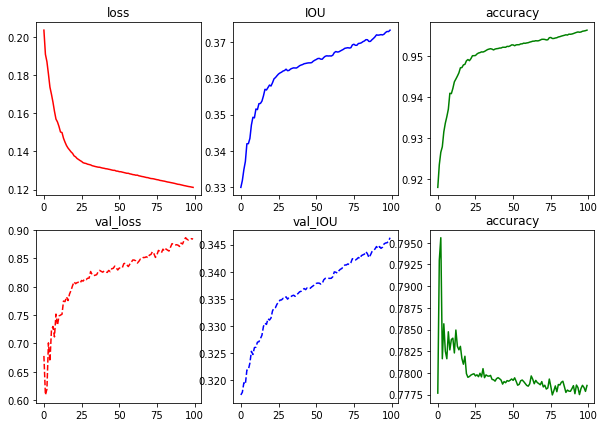

In [28]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(2, 3, figsize=(10, 7))

ax[0, 0].set_title('loss')
ax[0, 0].plot(history.history['loss'], 'r')
ax[0, 1].set_title('IOU')
ax[0, 1].plot(history.history['mean_io_u_1'], 'b')
ax[0, 2].set_title('accuracy')
ax[0, 2].plot(history.history['accuracy'], 'g')

ax[1, 0].set_title('val_loss')
ax[1, 0].plot(history.history['val_loss'], 'r--')
ax[1, 1].set_title('val_IOU')
ax[1, 1].plot(history.history['val_mean_io_u_1'], 'b--')
ax[1, 2].set_title('accuracy')
ax[1, 2].plot(history.history['val_accuracy'], 'g')

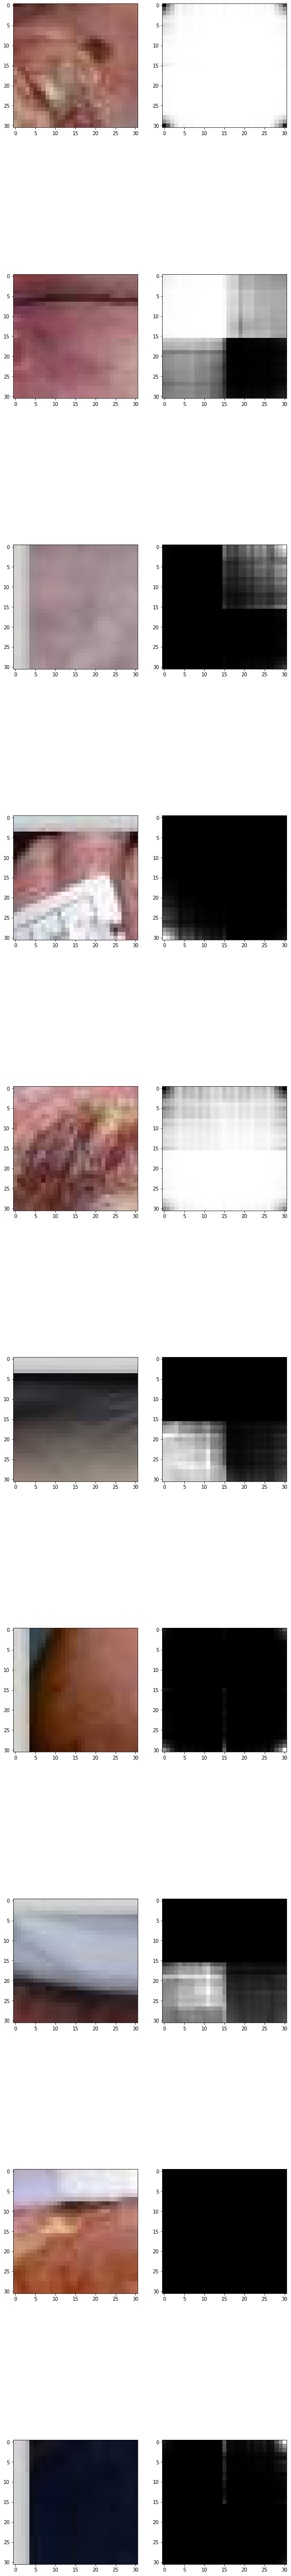

In [29]:
preds_val = model.predict(x_val[:10])

fig, ax = plt.subplots(len(preds_val), 2, figsize=(10, 100))

for i, pred in enumerate(preds_val):
    ax[i, 0].imshow(x_val[i].squeeze(), cmap='gray')
    #ax[i, 1].imshow(y_val[i].squeeze(), cmap='gray')
    ax[i, 1].imshow(pred.squeeze(), cmap='gray')

In [30]:


#이미지 불러오기

test_path = 'C:/MLDL/crop_test_result/necrosis/'
testmask_path = 'C:/MLDL/crop_test_mask_result/necrosis/'
test_list = os.listdir(test_path)
testmask_list = os.listdir(testmask_path)
#X를 uint8로 해야하나
X = np.zeros((len(test_list), 31,31, 3), dtype=np.uint8)
Y = np.zeros((len(testmask_list), 31,31, 1), dtype=np.bool)

for n, name in tqdm(enumerate(test_list), total=len(test_list)):
    path = test_path + name
    img = imread(path)
    img = resize(img, output_shape=(31,31,3), preserve_range=True)
    X[n]=np.array(img)

for n, maskname in tqdm(enumerate(testmask_list), total = len(testmask_list)):
#for n, maskname in enumerate(mask_list):
    path = testmask_path + maskname
    mask=imread(path,as_gray=True)
    mask = resize(mask, output_shape=(31,31,1), preserve_range=True)
    Y[n] = np.array(mask)
    
    

savepath='C:/MLDL/npy_test/necrosis/'
np.save(savepath+'x_test_necrosis', X)
np.save(savepath+'y_test_necrosis', Y)

100%|█████████████████████████████████████████████████████████████████████████████| 4788/4788 [00:28<00:00, 166.81it/s]


In [31]:
import numpy as np
x_test_necrosis=np.load('C:/MLDL/npy_test/necrosis/x_test_necrosis.npy')/255.
y_test_necrosis=np.load('C:/MLDL/npy_test/necrosis/y_test_necrosis.npy')


In [32]:
evaluation = model.evaluate(x_test_necrosis[:4788],y_test_necrosis, batch_size=10)

479/479 [==============================] - 7s 14ms/step - loss: 1.4959 - mean_io_u_1: 0.3796 - accuracy: 0.6400


In [33]:
preds = model.predict(x_test_necrosis[:4788])
preds[preds>=0.5] = 1
preds[preds<0.5]=0

(array([98.43912811,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0. 

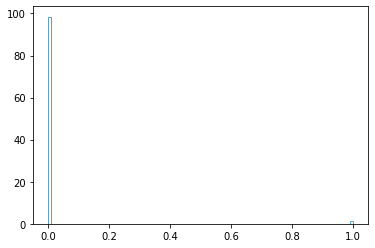

In [34]:
#prediction 값 분포를 보고 threshold 정하기
plt.hist(np.ravel(preds[0], order='C'), bins=100, density=True, alpha=0.7, histtype='step')

In [35]:
m=tf.keras.metrics.MeanIoU(num_classes=2)
m.update_state(y_test_necrosis,preds)
print(m.result())

tf.Tensor(0.40374947, shape=(), dtype=float32)


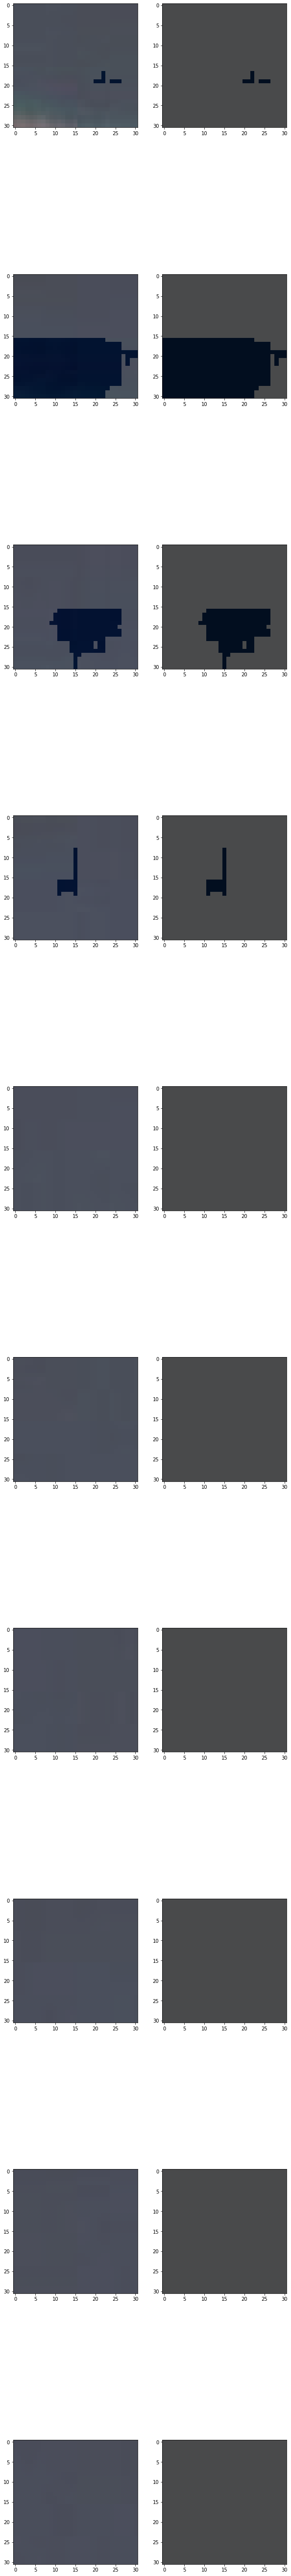

In [38]:
kernel = np.ones((5,5),np.uint8)
fig, ax = plt.subplots(len(x_test_necrosis[50:60]), 2, figsize=(10, 100))

for i, pred in enumerate(preds[50:60]):
    ax[i, 0].imshow(x_test_necrosis[i].squeeze(), cmap='gray')
    ax[i, 0].imshow(pred.squeeze(), cmap='Blues', alpha=0.3)
    ax[i, 1].imshow(y_test_necrosis[i].squeeze(), cmap='gray')
    ax[i, 1].imshow(pred.squeeze(), cmap='Blues', alpha=0.3)
  